In [73]:
%matplotlib inline
from ipywidgets import widgets
from math import sqrt
from IPython.display import display
from ipywidgets import interact, interactive, fixed, interact_manual
import os,glob, dicom, cv2, random, csv
import matplotlib.pyplot as plt
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv) 
from skimage import measure, morphology, segmentation, filters
from skimage.segmentation import clear_border, slic, mark_boundaries
from skimage.measure import label,regionprops, perimeter
from skimage.morphology import ball, disk, dilation, binary_erosion, remove_small_objects, erosion, closing, reconstruction, binary_closing, watershed
from skimage.util import img_as_float
from skimage.filters import roberts, sobel
from skimage.feature import blob_dog, blob_log, blob_doh
import scipy.ndimage as ndi
font = cv2.FONT_HERSHEY_SIMPLEX

In [74]:
def getSolution(patient):
    csvpath = "../KaggleData/stage1/stage1_solution.csv"
    with open(csvpath) as f:
        reader = csv.reader(f)
        n=0
        for row in reader:
            n += 1
            if n == patient:
                return row[0], row[1]

In [75]:
def get_slice_location(dcm):
    return float(dcm[0x0020, 0x1041].value)

# Returns a list of images for that patient_id, in ascending order of Slice Location
def load_patient(patient_id):
#     files = glob.glob('./KaggleData/sample_images/{}/*.dcm'.format(patient_id))
    files = patient_images
    imgs = {}
    for f in files:
        dcm = dicom.read_file(f)
        img = dcm.pixel_array
        img[img == -2000] = 0
        sl = get_slice_location(dcm)
        imgs[sl] = img
        
    # Not a very elegant way to do this
    sorted_imgs = [x[1] for x in sorted(imgs.items(), key=lambda x: x[0])]
    return sorted_imgs

In [76]:
def tr_mask(img):
    a = np.array([[263,312],[242,292],[212,241],[236,176],[276,220],[288,256],[263,312]])
    im1 = np.ones((img.shape[0], img.shape[1]))
    im1 = cv2.fillPoly(im1, [a], 0)
    hv = im1 == 0
    img[hv] = 0
    return img

In [77]:
def dcm2rgb(image):
    image2 = image.copy()
    image2[image2 == -2000] = 0
    for i in range(image2.shape[0]):
        for j in range(image2.shape[1]):
            image2[i][j] = np.interp(image2[i][j], [0,2250], [0,225])
    image2 = np.uint8(image2)
    image2 = cv2.cvtColor(image2, cv2.COLOR_GRAY2BGR)
    return image2

In [78]:
def segment_lungs(im, viz=False):
    im2 = im.copy()
    binary = im < 604
    
    if viz == True:
        fig, ax = plt.subplots(8,2, figsize=(20,20))
        ax[0][0].imshow(im, cmap='gray')
        ax[0][0].set_title("CT scan image")
        ax[0][1].imshow(binary, cmap='gray')
        ax[0][1].set_title("Binary image")
    cleared = clear_border(binary)
    
    if viz == True:
        ax[1][0].imshow(im, cmap='gray')
        ax[1][0].set_title("CT scan image")
        ax[1][1].imshow(cleared, cmap='gray')
        ax[1][1].set_title("Image after border is cleared")
    
    label_image = label(cleared)
    areas = [r.area for r in regionprops(label_image)]
    areas.sort()
    if len(areas) > 2:
        for region in regionprops(label_image):
            if region.area < areas[-2]:
                for coordinates in region.coords:                
                       label_image[coordinates[0], coordinates[1]] = 0
    if viz == True:
        ax[2][0].imshow(im, cmap='gray')
        ax[2][0].set_title("CT scan image")
        ax[2][1].imshow(label_image, cmap='gray')
        ax[2][1].set_title("Image after retaining 2 biggest connected components")
    
    binary = label_image > 0
    selem = disk(1)
    binary = binary_erosion(binary, selem)
    
    if viz == True:
        ax[3][0].imshow(im, cmap='gray')
        ax[3][0].set_title("CT scan image")
        ax[3][1].imshow(binary, cmap='gray')
        ax[3][1].set_title("Image after binary erosion")
    
    
    selem = disk(10)
    binary = binary_closing(binary, selem)
    edges = roberts(binary)
    
    if viz == True:
        ax[4][0].imshow(im, cmap='gray')
        ax[4][0].set_title("CT scan image")
        ax[4][1].imshow(edges, cmap='gray')
        ax[4][1].set_title("Image after roberts edge detection")
    
    
    binary = ndi.binary_fill_holes(edges)
    
    if viz == True:
        ax[5][0].imshow(im, cmap='gray')
        ax[5][0].set_title("CT scan image")
        ax[5][1].imshow(binary, cmap='gray')
        ax[5][1].set_title("Image after filling holes (Mask)")

    
    get_high_vals = binary == 0
    
    
    if viz == True:
        ax[6][0].imshow(im, cmap='gray')
        ax[6][0].set_title("CT scan image")
    
    im[get_high_vals] = 0 
    
    if viz == True:
        ax[6][1].imshow(im, cmap = 'gray')
        ax[6][1].set_title("Resulting segmented lung image")
    
    im[im <  604] = 0
    
    
    if viz == True:
        
        ax[7][0].imshow(im2, cmap='gray')
        ax[7][0].set_title("CT scan image")
        ax[7][1].imshow(im, cmap='gray')
        ax[7][1].set_title("Image after HU thresholding")
        ax[0][0].axis("off")
        ax[0][1].axis("off")
        ax[1][0].axis("off")
        ax[1][1].axis("off")
        ax[2][0].axis("off")
        ax[2][1].axis("off")
        ax[3][0].axis("off")
        ax[3][1].axis("off")
        ax[4][0].axis("off")
        ax[4][1].axis("off")
        ax[5][0].axis("off")
        ax[5][1].axis("off")
        ax[6][0].axis("off")
        ax[6][1].axis("off")
        ax[7][0].axis("off")
        ax[7][1].axis("off")
    return im

In [79]:
def segment_lung_from_ct_scan(ct_scan):
    return np.asarray([segment_lungs(slice) for slice in ct_scan])

In [80]:
def read_ct_scan(folder_name):
        # Read the slices from the dicom file
        slices = [dicom.read_file(folder_name + filename) for filename in os.listdir(folder_name)]
        
        # Sort the dicom slices in their respective order
        slices.sort(key=lambda x: int(x.InstanceNumber))
        
        # Get the pixel values for all the slices
        slices = np.stack([s.pixel_array for s in slices])
        slices[slices == -2000] = 0
        return slices

In [81]:
def blob_segments_simple(image, scan_image):
    image = np.array(image, np.uint8)
    dummy_image = np.zeros((image.shape[0], image.shape[1]))
    scan_image2 = scan_image.copy()
    params = cv2.SimpleBlobDetector_Params()
    # Change thresholds
    params.minThreshold = 1;
    params.maxThreshold = 605;
    
    # Filter by Area.
    params.filterByColor = True
    params.blobColor = 255
    #params.maxArea =500
    
    # Filter by Area.
    params.filterByArea = True
    params.minArea = 30
    params.maxArea =150

    # Filter by Circularity
    params.filterByCircularity = True
    params.minCircularity = 0.1

#     Filter by Convexity
    params.filterByConvexity = True
    params.minConvexity = 0.001

    # Filter by Inertia
    params.filterByInertia = True
    params.minInertiaRatio = 0.2
    
    detector = cv2.SimpleBlobDetector_create(params)
    keypoints = detector.detect(image)
    n_keypoints = len(keypoints)
    
    dummy_i = 1
    for kpt in keypoints:
        scan_image2 = cv2.putText(scan_image2, str(dummy_i), (int(kpt.pt[0])+int(kpt.size),int(kpt.pt[1])),\
                                                            font, 0.5,(255,255,0),2,cv2.LINE_AA)
        scan_image2 = cv2.circle(scan_image2, (int(kpt.pt[0]), int(kpt.pt[1])), int(kpt.size//2), color = (255,0,0), thickness =2 )
        scan_image = cv2.circle(scan_image, (int(kpt.pt[0]), int(kpt.pt[1])), int(kpt.size//2), color = (255,0,0), thickness =2 )
        dummy_image = cv2.circle(dummy_image, (int(kpt.pt[0]), int(kpt.pt[1])), int(kpt.size//2), color = (255,0,0), thickness = -1)
        dummy_i += 1
        
    points = dummy_image == 0
    image[points] = 0
    return image, dummy_image, scan_image, scan_image2

In [82]:
def visualize_regionprops(annotated_image, regions):
    
    fig, ax = plt.subplots(1,2, figsize = [15,15])
    fig.suptitle("Region properties for patient {0}".format(patient), fontsize = 18)
    
    ax[0].imshow(annotated_image, cmap='gray')
    ax[0].set_title("CT scan image of patient {0}".format(patient))
    ax[0].axis("off")
    
    if(regions):
        lenr = len(regions)*7.5
        ax[1].axis([0,180, 0, lenr])
        ax[1].set_title("Region properties of nodules in the image")
        ax[1].axis("off")
        ax[1].text(90, lenr-1, "Number of nodes in the image: {0}".format(len(regions)), color='black', fontsize=18, horizontalalignment='center')
        j = 2
        i = 1
        color = ["black","red", "blue", "black", "green", "blue", "red", "blue", "black", "green", "pink"]
        for region in regions:
            ax[1].text(10, lenr-j, "Nodule {0} area: {1} $pixel^2$".format(i, region.area), color=color[i], fontsize=14)
            ax[1].text(10, lenr-j-1, "Nodule {0} average eccentricity: {1}".format(i, region.eccentricity), color=color[i], fontsize=14)
            ax[1].text(10, lenr-j-2, "Nodule {0} average equivalent diameter: {1} pixel".format(i, region.equivalent_diameter), color=color[i], fontsize=14)
            ax[1].text(10, lenr-j-3, "Nodule {0} extent: {1}".format(i, region.extent), color=color[i], fontsize=14)
            ax[1].text(10, lenr-j-4, "Nodule {0} weighted X: {1} pixel".format(i, region.centroid[0]*region.area), color=color[i], fontsize=14)
            ax[1].text(10, lenr-j-5, "Nodule {0} weighted Y: {1} pixel".format(i, region.centroid[1]*region.area), color=color[i], fontsize=14)
            j += 6
            i += 1
    else:
        ax[1].axis([0,20,0,5])
#         ax[1].axis("off")
        ax[1].text(1,5, "There are no nodules in the image", color = "red", fontsize = 20)
    plt.show()

In [83]:
def visualize_axial(id):
    
    id = id + num_scans//4
    plt.close('all')
    fig, ax = plt.subplots(1,1)
    
    ax.imshow(ct_scan[id], cmap = plt.cm.bone)
    ax.set_title("Axial View of Patient: {0} CT slice number {1}/{2}".format(patient, id, num_scans))
    
    ax.axis('off')
    plt.show()

In [84]:
def visualize_saggital(id):
    
    id = id + 512//4
    plt.close('all')
    fig, ax = plt.subplots(1,1, figsize = (10,10))
    
    ax.imshow(ct_scan[:,:,id], cmap = plt.cm.bone)
    ax.set_title("Saggital View of Patient: {0} CT slice number {1}/{2}".format(patient, id, 512))  
    
    ax.axis('off')
    plt.show()

In [85]:
def visualize_coronal(id):

    id = id + 512//4
    plt.close('all')
    fig, ax = plt.subplots(1,1, figsize = (10,10))
    
    ax.imshow(ct_scan[:,id,:], cmap = plt.cm.bone)
    ax.set_title("Coronal View of Patient: {0} CT slice number {1}/{2}".format(patient, id, 512))  
    
    ax.axis('off')
    plt.show()

In [86]:
def dynamic_viz_temp(id):
    global idx
    plt.close('all')
#     id = int(input_text.value)
    id = id + len(ct_scan)//4
    image = ct_scan[id]
    image2 = image.copy()
    image2 = tr_mask(image2)
    image_seg = segment_lungs(image2)
    
    image_seg2 = image_seg.copy()
    
    image_nob, label_image, image_annotated, image_nob_numbered = blob_segments_simple(image_seg2, dcm2rgb(image.copy()))
    
    
    labeled_image = label(label_image)
    regions = regionprops(labeled_image, image_nob, cache=True) 
    if(regions):
        visualize_regionprops(image_nob_numbered, regions)
    else:
        visualize_regionprops(image_nob_numbered, 0)
    
    
#     fig, ax = plt.subplots(2,2, figsize = [20,20])
#     fig.suptitle("Segmentation process for patient {0}".format(patient), fontsize = 18)
#     ax[0,0].imshow(image, cmap='gray')
#     ax[0,0].set_title("CT scan image of patient {0}".format(patient))
    
#     ax[0,1].imshow(image_seg, cmap=plt.cm.bone)
#     ax[0,1].set_title("Segmented lung image")
    
#     ax[1,0].imshow(label_image, cmap=plt.cm.bone)
#     ax[1,0].set_title("Segmented label image of each nodules")
    
#     ax[1,1].imshow(image_nob_numbered, cmap=plt.cm.bone)
#     ax[1,1].set_title("Annotated image with nodules")
# #     plt.savefig("{0}_{1}.png".format(patient, id))
#     plt.show()

In [87]:
def plot_ct_scan(scan):
    f, plots = plt.subplots(int(scan.shape[0] / 20) + 1, 4, figsize=(25, 25))
    for i in range(0, scan.shape[0], 5):
        plots[int(i / 20), int((i % 20) / 5)].axis('off')
        plots[int(i / 20), int((i % 20) / 5)].imshow(scan[i], cmap=plt.cm.bone) 

In [88]:
image_folder = "../KaggleData/stage1/data/stage1/"
patients = os.listdir(image_folder)
randN = random.randint(0, 199)
patient, cancer_label = getSolution(randN)
patient, cancer_label = "e9a27e2645e1fad9434ce765f678585f", 1
 
ct_scan = read_ct_scan(image_folder+patient+"/")
num_scans = len(ct_scan)
annotated_images = []

save_fig = False
idx = len(ct_scan)//4

In [89]:
def on_button_clicked(b):
    global save_fig
    save_fig = True
    plt.savefig("{0}_{1}.png".format(patient, id))
    print("Saving figure")

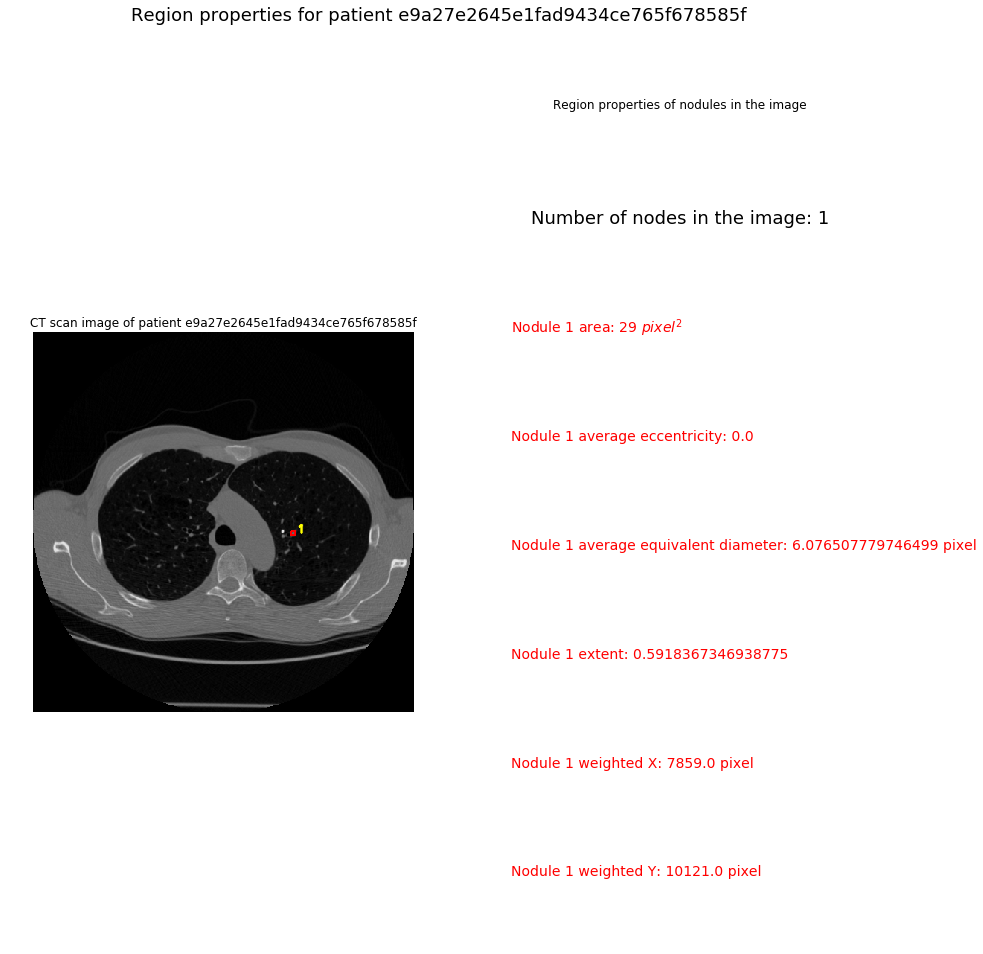

In [90]:
# interact(dynamic_viz_temp, id=len(ct_scan)//4)
# interact(visualize_axial, id=len(ct_scan)//4)
# interact(visualize_coronal, id=512//4)
# interact(visualize_saggital, id=512//4)
# button = widgets.Button(description = "Save figure")
# display(button)
# button.on_click(on_button_clicked)